# Ibis and Geospatial Operations

One of the most popular extensions to PostgreSQL is PostGIS,
which adds support for storing geospatial geometries,
as well as functionality for reasoning about and performing operations on those geometries.

This is a demo showing how to assemble ibis expressions for a PostGIS-enabled database.
We will be using a database that has been loaded with an [Open Street Map](https://www.openstreetmap.org/)
extract for Southern California.
This extract can be found [here](https://download.geofabrik.de/north-america/us/california/socal.html),
and loaded into PostGIS using a tool like [ogr2ogr](https://gdal.org/programs/ogr2ogr.html).

## Connecting to the database

We first make the relevant imports, and connect to the PostGIS database:

In [1]:
import os
import geopandas
import ibis

%matplotlib inline

In [2]:
client = ibis.postgres.connect(url=os.environ["POSTGRES_URI"])

Let's look at the tables available in the database:

In [3]:
client.list_tables(schema="osm")

['lines', 'multilinestrings', 'multipolygons', 'other_relations', 'points']

As you can see, this Open Street Map extract stores its data according to the geometry type.
Let's grab references to the polygon and line tables:

In [4]:
polygons = client.table('multipolygons', schema='osm')
lines = client.table('lines', schema='osm')

## Querying the data

We query the polygons table for shapes with an administrative level of 8,
which corresponds to municipalities.

We also reproject some of the column names so we don't have a name collision later.

In [5]:
cities = polygons[polygons.admin_level == '8']

cities = cities[
    cities.name.name('city_name'),
    cities.wkb_geometry.name('city_geometry')
]

We can assemble a specific query for the city of Los Angeles,
and execute it to get the geometry of the city.
This will be useful later when reasoning about other geospatial relationships in the LA area:

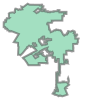

In [6]:
los_angeles = cities[cities.city_name == 'Los Angeles']
la_city = los_angeles.execute()
la_city_geom = la_city.iloc[0].city_geometry
la_city_geom

Let's also extract freeways from the lines table,
which are indicated by the value `'motorway'` in the highway column:

In [7]:
highways = lines[(lines.highway == 'motorway')]
highways = highways[
    highways.name.name('highway_name'),
    highways.wkb_geometry.name('highway_geometry')
]

## Making a spatial join

Let's test a spatial join by selecting all the highways that intersect the city of Los Angeles,
or one if its neighbors.

We begin by assembling an expression for Los Angeles and its neighbors.
We consider a city to be a neighbor if it has any point of intersection
(by this critereon we also get Los Angeles itself).

We can pass in the city geometry that we selected above when making our query by marking it as a literal value in `ibis`:

In [8]:
la_neighbors_expr = cities[
    cities.city_geometry.intersects(
        ibis.literal(la_city_geom, type='multipolygon;4326:geometry')
    )
]

In [9]:
la_neighbors = la_neighbors_expr.execute().dropna()
la_neighbors

,city_name,city_geometry
0,Inglewood,"(POLYGON ((-118.346107 33.932694, -118.346076 ..."
1,Long Beach,"(POLYGON ((-118.232975 33.714615, -118.231803 ..."
2,Vernon,"(POLYGON ((-118.204281 33.988934, -118.204265 ..."
3,Simi Valley,"(POLYGON ((-118.6334489 34.2697148, -118.63339..."
4,Los Angeles,"(POLYGON ((-118.464911 34.330061, -118.457574 ..."
5,Gardena,"(POLYGON ((-118.326689 33.91283, -118.326502 3..."
6,Commerce,"(POLYGON ((-118.127398 34.008033, -118.127411 ..."
7,Glendale,"(POLYGON ((-118.183869 34.148557, -118.18392 3..."
8,Rancho Palos Verdes,"(POLYGON ((-118.417912 33.762329, -118.415164 ..."
9,Lomita,"(POLYGON ((-118.30879 33.8022812, -118.308786 ..."


Now we join the neighbors expression with the freeways expression,
on the condition that the highways intersect any of the city geometries:

In [10]:
la_highways_expr = highways.inner_join(
    la_neighbors_expr,
    highways.highway_geometry.intersects(la_neighbors_expr.city_geometry)
).materialize()

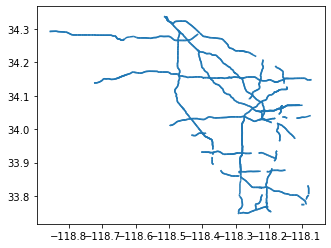

In [11]:
la_highways = la_highways_expr.execute()
la_highways.plot()

## Combining the results

Now that we have made a number of queries and joins, let's combine them into a single plot.
To make the plot a bit nicer, we can also load some shapefiles for the coast and land:

In [12]:
ocean = geopandas.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_ocean.zip')
land = geopandas.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_land.zip')

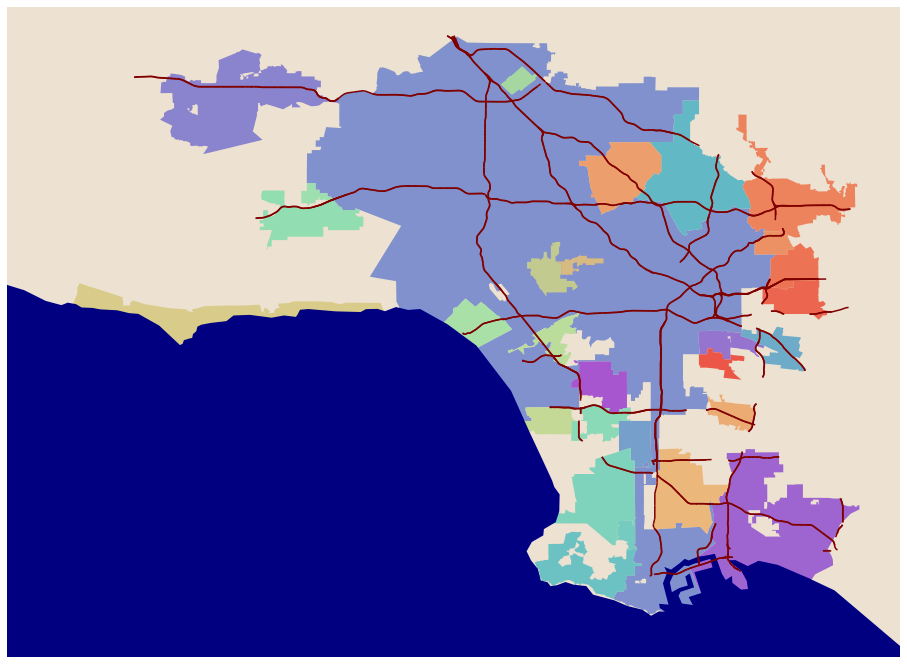

In [13]:
ax = la_neighbors.dropna().plot(figsize=(16,16), cmap='rainbow', alpha=0.9)
ax.set_autoscale_on(False)
ax.set_axis_off()
land.plot(ax=ax, color='tan', alpha=0.4)

ax = ocean.plot(ax=ax, color='navy')
la_highways.plot(ax=ax, color='maroon')